<a href="https://colab.research.google.com/github/alanbseo/LCAworkshop/blob/master/LCA_1_2_CoalLCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# install the BW package
!pip install brightway25

In [95]:
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa

import bw_processing as bwp

import os
import numpy as np
import seaborn as sb

In [96]:
# Exercise: CO2 emissions from 1 kWh coal-fired electricity in the US

# In our technosphere matrix, we will have four production exchanges (each of amount 1),
# and three consumption exchanges.
# Our biosphere matrix will only have one number, the emission of Iron ore from Iron mining.


# activity node
coal_mining = 101
rail_transportation = 102
electricity_generation = 103
petroleum_refining = 104 # diesel

coal = 200
co2 = 201


# Technosphere
elec_t_data = np.array([
    1,   # production of petroleum refining
    1,   # production of coal mining
    1,   # production of rail transportation
    1,   # production of electricity generation
    0.006482, # input of petroleum refining (tkm)
    0.44186, # input of coal mining
    0.46079  # input of rail transportation
])

# We need integer indices for each concept. The numbers themselves are arbitrary,
# the point is that we will use them consistently in the datapackages, and maintain a mapping from our concepts to these numbers.

elec_t_indices = np.array([
    (104, 104), # production of petroleum refining
    (101, 101), # production of coal mining
    (102, 102), # production of rail transportation
    (103, 103), # production of electricity generation
    (104, 102), # input of petroleum refining
    (101, 102), # input of coal mining
    (102, 103)  # input of rail transportation
    ],
    dtype=bwp.INDICES_DTYPE
)
elec_t_flip = np.array([ False, False, False, False, True, True, True]) # Numerical sign of the inputs needs to be flipped negative

# Biosphere
elec_b_data = np.array([1.235,     # emission of coal (coal mining)
                        0,         # emission of co2 (coal mining) - ignored
                        0.018949,  # emission of co2 (rail transporation)
                        0.99407])  # emission of co2 (electricity)
elec_b_indices = np.array([
    (200, 101), # emission of coal (coal mining)
    (201, 101), # emission of co2 (coal mining)
    (201, 102), # emission of co2 (rail transportation)
    (201, 103), # emission of co2 (electicity geneneration)
    ],
    dtype=bwp.INDICES_DTYPE
)

# Characterization matrix
elec_c_data = np.array([0, 1]) # ignore coal emission

# try with the coal emission
# elec_c_data = np.array([1, 1]) # consider coal emission - need a proper conversion factor

elec_c_indices = np.array([
    (200, 200), # coal
    (201, 201), # cf of co2
    ],
    dtype=bwp.INDICES_DTYPE
)





In [97]:
# The main interface for using this library is the Datapackage class. You should use the utility functions create_datapackage and load_datapackage.
# A datapackage is a set of file objects (either in-memory or on disk) that includes a metadata file object, and one or more data resource files objects.
# The metadata file object includes both generic metadata (i.e. when it was created, the data license) and metadata specific to each data resource (how it can be used in calculations, its relationship to other data resources).

elec_dp_static = bwp.create_datapackage()

elec_dp_static.add_persistent_vector(
    matrix='technosphere_matrix',
    indices_array=elec_t_indices,
    data_array=elec_t_data,
    flip_array=elec_t_flip,
)
elec_dp_static.add_persistent_vector(
    matrix='biosphere_matrix',
    indices_array=elec_b_indices,
    data_array=elec_b_data,
)
elec_dp_static.add_persistent_vector(
    matrix='characterization_matrix',
    indices_array=elec_c_indices,
    data_array=elec_c_data,
)

# Base class for single and multi LCA classes
elec_lca = bc.LCA(
    demand={electricity_generation: 1},
    data_objs=[elec_dp_static],
)

elec_lca

# The LC inventory. Calculate a life cycle inventory.
elec_lca.lci()
# 1) Load LCI data, and construct the technosphere and biosphere matrices.
# 2) Build the demand array
# 3) Solve the linear system to get the supply array and life cycle inventory.

elec_lca.lcia() # Calculate the life cycle impact assessment.
# 1) Load and construct the characterization matrix
# 2) Multiply the characterization matrix by the life cycle inventory

elec_lca.score # The LCIA score as a float.
# means 1.25 iron ore * 1.1 kg iron mining * 8 kg steal

1.00280150971

# A stochastic LCA

We can make our example more interesting by adding uncertainty. To do this, we will use the standards in the [stats_arrays](https://stats-arrays.readthedocs.io/en/latest/) library.
*kursiver Text*
We will only add uncertainty to the inputs, and the CO2 emission. The other edges will have uncertainty type zero - no uncertainty.

In [98]:
elec_t_uncertainty = np.array([
        (0, 1, np.NaN, np.NaN, np.NaN, np.NaN, False), #static
        (0, 1, np.NaN, np.NaN, np.NaN, np.NaN, False), #static
        (0, 1, np.NaN, np.NaN, np.NaN, np.NaN, False), #static
        (0, 1, np.NaN, np.NaN, np.NaN, np.NaN, False), #static
        (5, 0.006482, np.NaN, np.NaN, 0.005, 0.008, False), # triangular uncertainty from 0.005 to 0.008
        (5, 0.44186, np.NaN, np.NaN, 0.3, 0.6, False), # triangular uncertainty from 0.3 to 0.6
        (5, 0.46079, np.NaN, np.NaN, 0.1, 0.8, False), # triangular uncertainty from 0.1 to 0.8
    ],
    dtype=bwp.UNCERTAINTY_DTYPE
)

elec_b_uncertainty = np.array([
        (3, 1.235, 0.2, np.NaN, np.NaN, np.NaN, False), # normal uncertainty with std. dev. of 0.2
        (0, 0, 0, np.NaN, np.NaN, np.NaN, False), # static
        (5, 0.018949, np.NaN, np.NaN, 0.01, 0.03, False), # triangular uncertainty from 0.01 to 0.03
        (3, 0.99407, 0.1, np.NaN, np.NaN, np.NaN, False), # normal uncertainty with std. dev. of 0.1
    ],
    dtype=bwp.UNCERTAINTY_DTYPE
)


In [101]:
elec_dp_stochastic = bwp.create_datapackage()

elec_dp_stochastic.add_persistent_vector(
    matrix='technosphere_matrix',
    indices_array=elec_t_indices,
    data_array=elec_t_data,
    flip_array=elec_t_flip,
    distributions_array=elec_t_uncertainty,
)

elec_dp_stochastic.add_persistent_vector(
    matrix='biosphere_matrix',
    indices_array=elec_b_indices,
    data_array=elec_b_data,
    distributions_array=elec_b_uncertainty,
)

elec_dp_stochastic.add_persistent_vector(
    matrix='characterization_matrix',
    indices_array=elec_c_indices,
    data_array=elec_c_data,
)

In [104]:
elec_lca_sto = bc.LCA(
    demand={electricity_generation: 1},
    data_objs=[elec_dp_stochastic],
    use_distributions=True, # To use uncertainty, we tell the LCA object to use the probability distributions.
)
elec_lca_sto.lci()
elec_lca_sto.lcia()

elec_mc_results = [elec_lca_sto.score for _ in zip(range(100), elec_lca_sto)] # Repeat 100 times as zip() makes an iterator that aggregates elements from each of the iterables.

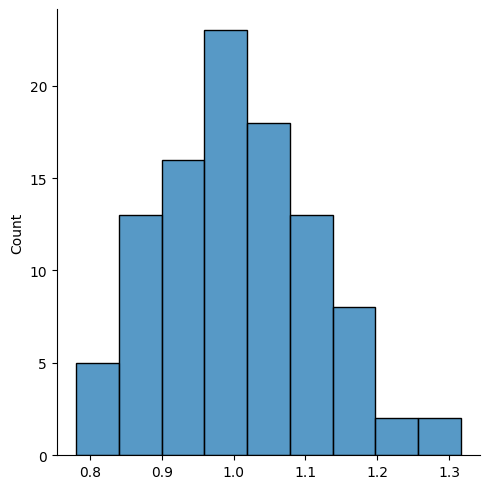

In [103]:
sb.displot(np.array(elec_mc_results))

# Using arrays for scenarios

Let's imagine two different possibilities: a shorter transporation and less co2 emission. If we treat these as separate possibilities, we have four scenarios in total.

For this to work, we will need to create **two** new arrays, one for each choice, and then tell the software to do combinatorial sampling:

In [137]:
elec_dp_scenarios = bwp.create_datapackage(combinatorial=True)

elec_dp_scenarios.add_persistent_array(
    matrix='technosphere_matrix',
    indices_array=np.array([(102, 103)], dtype=bwp.INDICES_DTYPE),
    data_array=np.array([(0.46079, 0.46079/2)]),
    flip_array=np.array([True]),
    name='shorter transportation' # shorter transporation
)

elec_dp_scenarios.add_persistent_array(
    matrix='technosphere_matrix',
    indices_array=np.array([(101, 102)], dtype=bwp.INDICES_DTYPE),
    data_array=np.array([(0.44186, 0.44186/2)]), # less coal
    name='less coal'
)

# elec_dp_scenarios.add_persistent_array(
#     matrix='biosphere_matrix',
#     indices_array=np.array([(201, 102)], dtype=bwp.INDICES_DTYPE),
#     data_array=np.array([(0.018949, 0.018949/2)]), # less emission from transportation
#     name='less co2 emission (elec generation)'
# )

In [143]:
scenario_mapping = {
    (0, 0): "Baseline",
    (0, 1): "Shorter transportation distance",
    (1, 0): "Less coal",
    (1, 1): "Shorter distance & less coal",
}

In [144]:
 #run LCA calculations again with method
 elec_lca_scenarios = bc.LCA(
    demand={electricity_generation: 1},
    data_objs=[elec_dp_static, elec_dp_scenarios],
    use_arrays=True,
)

elec_lca_scenarios.lci()
elec_lca_scenarios.lcia()

print(elec_lca_scenarios.score) # doesn't print the sceanario outcomes


1.00280150971


In [165]:
elec_lca_scenarios.technosphere_mm.groups

(<matrix_utils.resource_group.ResourceGroup at 0x7cf5da981900>,
 <matrix_utils.resource_group.ResourceGroup at 0x7cf5da981f90>)

In [151]:
resource_group = next(grp for grp in elec_lca_scenarios.technosphere_mm.groups if grp.label == 'shorter transportation').indexer.indexer

In [166]:
print(elec_lca_scenarios.score, scenario_mapping[resource_group.index])

for scenario_result in elec_lca_scenarios:
    print(elec_lca_scenarios.score, scenario_mapping[resource_group.index])

1.00280150971 Baseline
1.00280150971 Shorter transportation distance
0.998435754855 Less coal
0.998435754855 Shorter distance & less coal
